In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
import os, sys
import numpy as np
import pandas as pd

import config_readwrite as crw

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

In [3]:
CL = "HEPG2"
DATAHEPG2 = config["mpra"][f'{CL}.clean.transformed'] 

CL = "BJ"
DATABJ = config["mpra"][f'{CL}.clean.transformed'] 
ANALYSIS = 'Pos.US_UP0.9_v_pos.US_UP0.1_shuf_Pos.CTRL_UP0.9'

FASTA = config["mpra"]["fasta"]

MEME = config["meme"]["src"]
FIMO = config["fimo"]["src"]
RESULTS = config["path"]["results"]
BED = config["mpra"]["tile.bed"]

RE_MEME = os.path.join(RESULTS, "meme")
RE_MEME_CL = os.path.join(RE_MEME, CL, ANALYSIS)

# make the results
for dirname in [RE_MEME, RE_MEME_CL]:
    if os.path.exists(dirname) is False:
        os.mkdir(dirname)

# append meme path
sys.path.append(MEME)

# change directory 
os.chdir(RE_MEME_CL)

In [4]:
# write

section = "meme"

config[section][f'results'] = RE_MEME
config[section][CL] = RE_MEME_CL

crw.write(config, cfn)

# load data

In [5]:
def openAndFilter(file_name):
    df = pd.read_csv(file_name, sep='\t')  # (58333, 38)
    print("before filtering", file_name,  df.shape)
    df = df.loc[~df["label"].str.contains("Synthetic")].reset_index(
        drop=True)  # (26803, 38)
    print("filter out synthetics", df.shape)
    df = df.loc[~df["label"].str.contains("Pos")].reset_index(
        drop=True)  # (26659, 38)
    print("filter out positive controls", df.shape, '\n\n')

    return df

In [6]:
#hepg2 = openAndFilter(DATAHEPG2)
bj = openAndFilter(DATABJ)

before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_bj_MPRA.clean.transformed.csv (58333, 38)
filter out synthetics (26803, 38)
filter out positive controls (26659, 38) 




In [7]:
bj.shape

(26659, 38)

In [8]:
enh = pd.read_csv(BED, sep='\t')
enh.head()

,name,enh.id,enh.name
0,hob_k27ac_down_chr1:826978-827247,chr1:826978-827704,enh.0
1,hob_k27ac_down_chr1:827110-827379,chr1:826978-827704,enh.0
2,hob_k27ac_down_chr1:827377-827646,chr1:826978-827704,enh.0
3,hob_k27ac_down_chr1:827435-827704,chr1:826978-827704,enh.0
4,hob_k27ac_down_chr1:827891-828160,chr1:827891-828160,enh.1


In [9]:
bj = pd.merge(bj, enh, how="left")

# add direction 

In [10]:
def labelDirection(df):

    """label sequences with different directions of change between US and Control
    note

    neg.US_UP == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    pos.US_UP  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    US_UP == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Pos values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Pos.US_UP"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Pos.CTRL_UP"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Neg.CTRL_DOWN"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Neg.US_DOWN"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "US_UP"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "CTRL_UP"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


In [11]:
bj = labelDirection(bj)

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean      direction
10994            0.382578          0.482686    0.100108      Pos.US_UP
13215            0.056176          0.163504    0.107329      Pos.US_UP
21023            0.341647          0.329346   -0.012301    Pos.CTRL_UP
14474           -0.166170         -0.116797    0.049374  Neg.CTRL_DOWN
26009            0.072193          0.069302   -0.002891    Pos.CTRL_UP
13440           -0.024974         -0.011175    0.013799  Neg.CTRL_DOWN
25698            0.219006          0.217846   -0.001161    Pos.CTRL_UP
15382           -0.122232         -0.093925    0.028307  Neg.CTRL_DOWN
15484            0.276115          0.308738    0.032622      Pos.US_UP
2973             0.169931          0.218986    0.049055      Pos.US_UP
26103           -1.110899         -1.098531    0.012368  Neg.CTRL_DOWN
9082            -2.174164         -2.665185   -0.491021    Neg.US_DOWN
5216             0.501056          0.570590    0.069534      Pos.US_UP
25108 

In [12]:
set(bj["label"])

{'Differential_ATAC',
 'Differential_H3K27ac',
 'NegCtl_Ilias_MPRA',
 'NegCtl_Vikram_MPRA',
 'Non-differential',
 'Promoter_DEG',
 'Shuffle'}

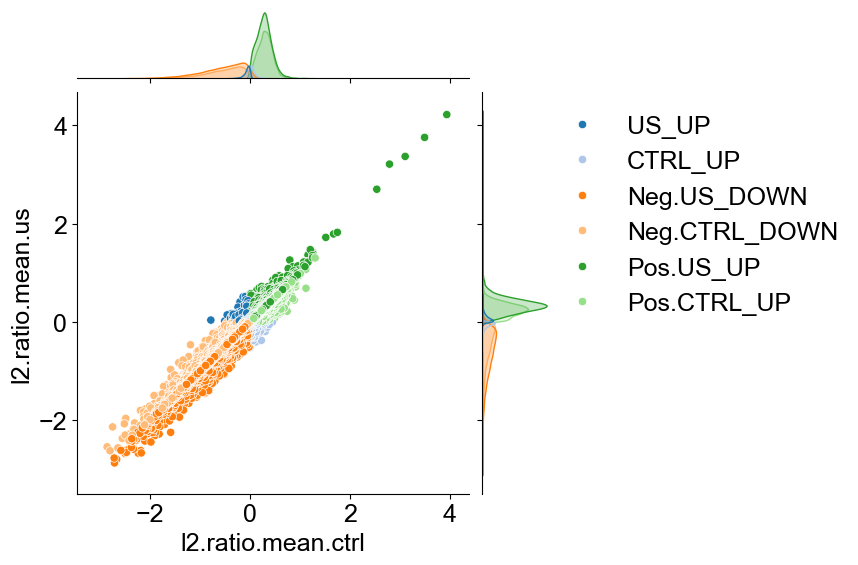

In [13]:
# 
#fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=bj, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

# US up - BJ

## functions

In [14]:
def getDfDirectionSub(df, direction):
    """subset dataframe by directino of effect"""

    cols = ["name", "label", "l2.ratio.mean.ctrl",
        'l2.ratio.mean.us', "delta.mean", "direction"]

    df = df.loc[df["direction"] == direction, cols].sort_values(
        by='l2.ratio.mean.us', ascending=False).copy()

    return df


def getQuantileDelta(df, top_quantile, base_df, shuf_bkgd=False):
    """subset dataframe by delta.mean top/bottom quantiles, return dataframes, list of names"""

    # top quantile of delta.means
    pos = df.loc[df["delta.mean"] >=
                     df["delta.mean"].quantile(top_quantile)].copy()

    # pos list of names
    pos_names = list(pos["name"])

    # bottom quantile of delta.means.
    neg = df.loc[df["delta.mean"] <=
                     df["delta.mean"].quantile(1-top_quantile)].copy()
    if shuf_bkgd is True:
        shuf = base_df.loc[base_df['label'] ==
            "Shuffle"].copy().drop_duplicates()
        neg = pd.concat([neg, shuf])

    # neg list of names
    neg_names = list(neg["name"])

    return pos, pos_names, neg, neg_names


def makeQuantileFasta(pos_names, neg_names, direction, re, top_quantile, exp_name, fa):
    """write fastas for each quantile based on list of sequence names"""

    bottom_quantile = round(1-top_quantile, 1)

    # files to write
    FA_POS = os.path.join(re, f"{exp_name}.{direction}.pos.{top_quantile}.fa")
    FA_NEG = os.path.join(
        re, f"{exp_name}.{direction}.neg.{bottom_quantile}.fa")

    # write positive, negative names and sequences
    for names, fa_write in [(pos_names, FA_POS), (neg_names, FA_NEG)]:

        # filter and write fasta function
        filterWriteFasta(fa_write, fa, names)

    return FA_POS, FA_NEG


def filterWriteFasta(fa_write_file, source_fa, seq_id_list):
    """provide file to write, source fasta, and sequence list"""
    fa_writer = open(fa_write_file, "w")  # open fa file to write

    with open(source_fa, "r") as reader:  # open the full fa file
        for value in sfp(reader):
            seq_id, seq = value  # get sequence id, sequence
            if seq_id in seq_id_list:  # filter for sequences in pos/neg name list
                # write those sequences to fa
                fa_writer.write(f'>{seq_id}\n{seq}\n')
    fa_writer.close()

def getEnhSet(df, name_set):
    """return list of enhancer names and linked tiles to prevent data leakage"""
    enh_names = df.loc[df["name"].isin(name_set), "enh.name"].unique()
    linkedtiles = df.loc[df["enh.name"].isin(enh_names), "name"].unique()
    
    return enh_names, linkedtiles

def runFimo(fimo, meme_txt, fa, direction, quantile):

    OUTDIR = f"./fimo/{direction}.{quantile}"
    if os.path.exists('./fimo') is False:
        os.mkdir("./fimo/")

    cmd = " ".join([fimo,
                    "--oc",
                    OUTDIR,
                    meme_txt,
                    fa,

                    ])
    if os.path.exists(OUTDIR) is False:
        os.system(cmd)

    return OUTDIR

## Experiment 1: Motif discovery on top 10% of US-increasing sequences v. bottom 10% of US-increasing sequences. 
     - Hyp - top 10% reflects true signal, bottom 10% is noise, the shuffles are noise, the repressed sequences are a different set of elements. Motifs enriched in the top 10% of US-sensitive elements not found in bottom 10% are likely important for US-dependent TF binding. 
    - Data Universe: BJ MPRA, all of the sequences where the contrl MPRA value is negative and US MPRA value is positive

In [15]:
EXP_NAME ="exp1"
DIRECTION = "Pos.US_UP"
NEG_DIRECTION="Pos.CTRL_UP"
df = bj
TOP_QUANTILE = 0.9
BOTTOM_QUANTILE = round((1-TOP_QUANTILE),1)

### US-increasing sequences only

In [16]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)
neg_df_dir = getDfDirectionSub(df, NEG_DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, True)
print(len(neg_names))
# top US_down elements to add to the background
neg_pos, neg_pos_names, neg_neg, neg_neg_names = getQuantileDelta(neg_df_dir, TOP_QUANTILE, df, True)

# add top_US_down names to the negative list. 
neg_names.extend(neg_neg_names)
neg = pd.concat([neg, neg_neg])
print(len(neg_names))
# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names, neg_names, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

exp1up, exp1down = pos_names, neg_names

1240
2207


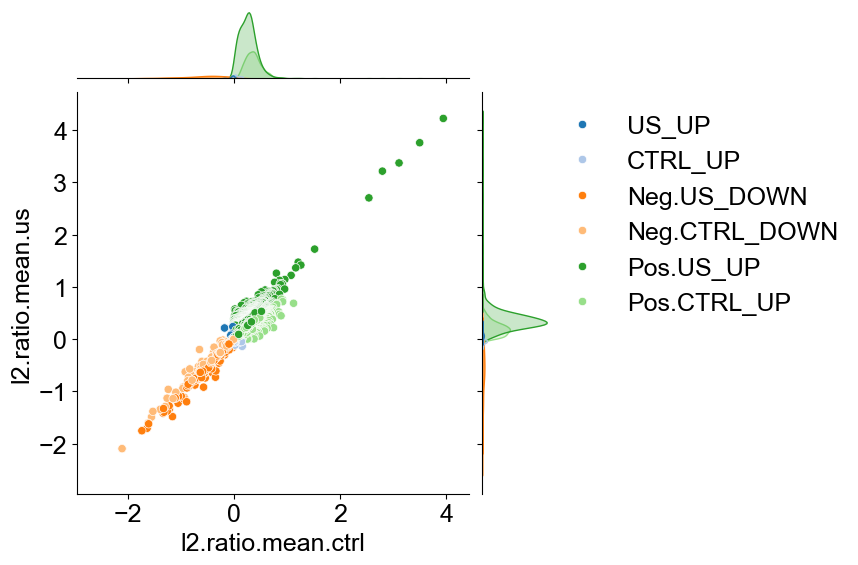

In [17]:
plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### sanity check - delta scores are larger than expected from shuffle.  

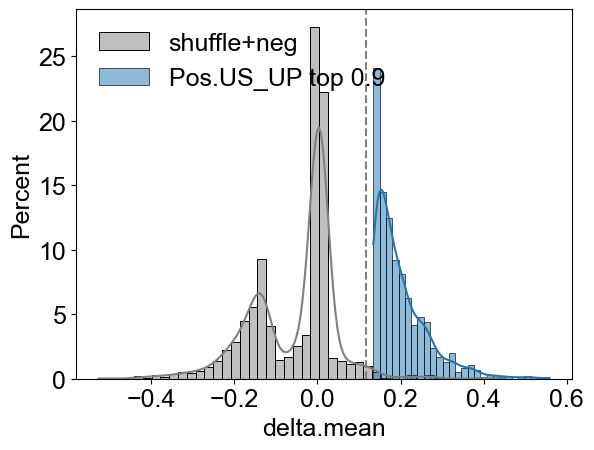

In [18]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=neg, label="shuffle+neg", kde=True,
             stat="percent", color="grey", common_norm=False)

# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
plt.legend(frameon=False, loc="upper left")



#### delta.mean stats - shuf, us_up

In [19]:
neg["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

(0.11714332102258816,
 count    938.000000
 mean       0.199157
 std        0.065295
 min        0.134542
 25%        0.150366
 50%        0.178526
 75%        0.226405
 max        0.558532
 Name: delta.mean, dtype: float64)

### MEME motif discovery

#### MEME params

In [20]:
# MEME PARAMS - https://meme-suite.org/meme/doc/meme.html?man_type=web
OUTPUT_DIR = RE_MEME_CL
OBJ_FUN = "de" # differential enrichment, uses multiple hypergeometric test (mhg) as stat to measure enrichment
TEST = "mhg"
MIN_WIDTH = 10
MAX_WIDTH = 15

N_SITES = 124  # find motifs with N sites
N_MOTIFS = 3 # n motifes to find

#### MEME cmd, run

In [21]:
args = [FA_POS,
        "-oc", OUTPUT_DIR,
        '-objfun', OBJ_FUN,
        "-neg", FA_NEG,
        "-dna",  # use DNA alphabet
        "-minw", MIN_WIDTH,
        '-maxw', MAX_WIDTH,
        "-allw",  # test starts for all widths
        "-nsites", N_SITES,  # number of sites for each motif
        "-nmotifs", N_MOTIFS
        ]

# add meme args together
cmd = [MEME] + args

# transform into a str
cmd = " ".join([str(i) for i in cmd])

# write the output meme file
MEME_TXT = os.path.join(RE_MEME_CL, f"{CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

if os.path.exists(MEME_TXT) is False:

    # run MEME command
    os.system(cmd)


    # rename the membe file
    os.system(f"mv meme.txt {CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

    config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.meme'] = MEME_TXT

    crw.write(config, cfn)

The output directory '/wynton/group/ahituv/fongsl/projects/US/results/meme/BJ/Pos.US_UP0.9_v_pos.US_UP0.1_shuf_Pos.CTRL_UP0.9' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (de): n 932 p0 371 p1 280 p2 281
CONTROL (de): n 1882 c0 371 c1 755 c2 756
SEQUENCE GROUP USAGE-- Starts/EM: p0 vs c0; Trim: p1 vs c1; pvalue: p2 vs c1,c2; nsites: p0,p1,p2 vs c0,c1,c2
SEEDS: maxwords 60316 highwater mark: seq 232 pos 15
all widths from min to max

seqs=   932, min_w= 270, max_w=  270, total_size=   251640

motif=1
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15


### MEME output
     /wynton/group/ahituv/fongsl/projects/US/results/meme/BJ

In [22]:
%%bash
ls -l /wynton/group/ahituv/fongsl/projects/US/results/meme/BJ

### Fimo on full dataset

        # without repressed (CTRL_UP, top 90%) in bkgd
         top 90% US_UP bkgd discovered motifs with bkgd - bottom 10% US_UP, shuffle bkgd
        CAGRCTCTCS
        CCTGKRTGWGW
        GAGRAGVMAGCMK
        
        
        # WITH repressed in bkgd
        top 90% US_UP bkgd discovered motifs with bkgd - bottom 10% US_UP, shuffle bkgd, and CTRL_UP top 90% (repressed) 
        TCTTCCTSCT
        SCWGCAGHKCCM
        CYTGGGAGGAG
        

In [23]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

In [24]:
%%bash
ls -l

In [25]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)


bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'shuf+bottom0.1+top0.9repressed'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)

In [26]:
# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

plot = plot.loc[~plot["motif_alt_id"].isna()]

In [27]:
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper right')

In [28]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

# Validation

## Experiment 2: are motifs discovered in US_UP also discovered in POS.US_UP?
    - hypothesis: top motifs in us_up are also driving increased activity in pos.US_up. 
    - approach: use FIMO to discover US_UP motifs in other data. 
    - data universe: sequences with positive baseline activity that increase activity w/ US

In [29]:
EXP_NAME ="exp2"
DIRECTION = "US_UP"

### pos.us_up sequences only

In [30]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means, no shuffle data leakage
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### clean up data leakage
- tiled enhancers which may have overlapping information

In [31]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [32]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

### sanity check

In [33]:
pos.shape, neg.shape

In [34]:
neg["delta.mean"].describe()

In [35]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

plt.legend(frameon=False, loc="upper left")



shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

### Fimo

In [36]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

### FET enrichment

In [37]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper left')

In [38]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

In [39]:
plot.groupby(["motif_alt_id", "quantile"]).count()

In [40]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

## Experiment 3 - motif enrichment in repressed sequences? 

In [41]:
EXP_NAME ="exp3"
DIRECTION = "CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [42]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [43]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [44]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

In [45]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper left')

In [46]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

In [47]:
plot.groupby(["motif_alt_id", "quantile"]).count()

In [48]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

## Experiment 4 - motifs in repressed sequences (CTRL positive, US reduced positive)

In [49]:
EXP_NAME ="exp4"
DIRECTION = "Pos.CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [50]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [51]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [52]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

In [53]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

In [54]:
bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
#bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

In [55]:
# concatenate the top and bottom values
if bdf.shape[0]>3:
    plot = pd.concat([tdf, bdf])
else:
    plot=tdf
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper left')

In [56]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

In [ ]:
plot.groupby(["motif_alt_id", "quantile"]).count()

In [ ]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

# luciferase tested elements. 

## load experiment data 

In [ ]:
LUC="/wynton/group/ahituv/fongsl/projects/US/data/validation_luc/Candidate_ID_table_luc.txt"

luc = pd.read_csv(LUC, sep='\t')

luc_names = list(luc["insert"])  # list of tiles tested in luciferase


# successful results where luciferase direction matches 
success = ["BJ_D2", "BJ_D3", "BJ_D4", "BJ_D7", "BJ_D8", 'BJ_D9', "BJ_U9"]

# annotate dataframe with sucesses
luc["success"] = False
luc.loc[luc["Sample name"].isin(success), "success"] = True
#luc.loc[~luc["Sample name"].str.contains(CL), "success"] = "other-cl"

luc.rename(columns = {"insert":"sequence_name", 
                     "Sample name": 'label_id'}, inplace=True)
luc

## make fasta

In [ ]:
LUC_FA = LUC.strip(".txt") + '.fa'
filterWriteFasta(LUC_FA, FASTA, luc_names)

## fimo

In [ ]:
OUTDIR_LUC =  runFimo(FIMO, MEME_TXT, LUC_FA, "Luc", "all")

In [ ]:
pred = os.path.join(OUTDIR_LUC, "fimo.tsv")

tdf = pd.read_csv(pred, sep='\t')
tdf["quantile"] = 'LUC.matches'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf = tdf.loc[~tdf["motif_alt_id"].isna()]
tdf

In [ ]:
luc_fimo = pd.merge(luc[["label_id", "sequence_name", "success"]],
                    tdf, how="right").sort_values(by='success', ascending=False)
luc_fimo['label_id_success'] = luc_fimo["label_id"] + ".success." + luc_fimo['success'].map(str)

In [ ]:
x="motif_alt_id"
y="-log10q"
hue="label_id_success"
order=["MEME-1", "MEME-2", "MEME-3"]
data=luc_fimo.loc[luc_fimo["label_id"].str.contains(CL)].sort_values(by='success', ascending=False)

fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(x=x,y=y, hue=hue, order=order, jitter=True,
              data=data, dodge = True, s=10)
ax.set(title=f"{CL} luciferase")
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(title="success", frameon=False, bbox_to_anchor=(1,1))

In [ ]:
data.reset_index()

In [ ]:
table = data.groupby(["motif_alt_id", "label_id", "success"])['-log10q'].max().reset_index(
).pivot(index="motif_alt_id", columns=[ "label_id",], values="-log10q")#.fillna(0)

In [ ]:
sns.heatmap(table,
            mask=table<np.log10(0.05)*-1, 
            square=True, cmap="bwr", 
            annot=True, 
            cbar_kws={"label":"-log10q"}
           )